In [3]:
import numpy as np
import random

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

# Import data

In [6]:
DATA_FOLDER = "competition-data/"
DATA_TEST = "test.csv"
DATA_TRAIN = "train.csv"

In [7]:
from proj1_helpers import load_csv_data
y_train, x_train, ids_train = load_csv_data(DATA_FOLDER + DATA_TRAIN)
#y_test, x_test, ids_test = load_csv_data(DATA_FOLDER + DATA_TEST)

In [4]:
#y_train = rename_y(1, 0, y_train)

In [8]:
x_train

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ...,      nan,      nan,   46.226],
       [     nan,  162.172,  125.953, ...,      nan,      nan,   44.251],
       ..., 
       [ 105.457,   60.526,   75.839, ...,      nan,      nan,   41.992],
       [  94.951,   19.362,   68.812, ...,      nan,      nan,    0.   ],
       [     nan,   72.756,   70.831, ...,      nan,      nan,    0.   ]])

In [9]:
tx_train = x_train.T

# Cleaning data

In [252]:
"""# constants
CATEGORICAL_FIELDS = ['PRI_jet_num']

for c in CATEGORICAL_FIELDS:
    median_rep_data_train[c] = categorical_rep_data(train_data[c])
    median_rep_data_test[c] = categorical_rep_data(test_data[c])"""

"# constants\nCATEGORICAL_FIELDS = ['PRI_jet_num']\n\nfor c in CATEGORICAL_FIELDS:\n    median_rep_data_train[c] = categorical_rep_data(train_data[c])\n    median_rep_data_test[c] = categorical_rep_data(test_data[c])"

In [10]:
from implementations import *
tx_train = delete_features(tx_train, 0.9)
tx_train.shape

(30, 250000)

In [11]:
from implementations import *
tx_train = replace_nan_by_median(tx_train)

In [196]:
tx_train = min_max(tx_train)

In [12]:
mean_train, std_train, tx_train = standardize(tx_train)
tx_train

array([[  3.41522310e-01,   7.66557821e-01,  -1.51562016e-01, ...,
         -2.83024684e-01,  -4.81779439e-01,  -1.51562016e-01],
       [  6.83319669e-02,   5.52504823e-01,   3.19515553e+00, ...,
          3.19316447e-01,  -8.45323970e-01,   6.65336083e-01],
       [  4.07680272e-01,   5.40136414e-01,   1.09655998e+00, ...,
         -1.30863670e-01,  -3.02973380e-01,  -2.53522760e-01],
       ..., 
       [  1.14262161e+00,   4.89238340e-04,   4.89238340e-04, ...,
          4.89238340e-04,   4.89238340e-04,   4.89238340e-04],
       [ -2.52683989e+00,  -1.23840760e-04,  -1.23840760e-04, ...,
         -1.23840760e-04,  -1.23840760e-04,  -1.23840760e-04],
       [  4.12510497e-01,  -2.73819964e-01,  -2.93969845e-01, ...,
         -3.17017229e-01,  -7.45439413e-01,  -7.45439413e-01]])

In [13]:
tx_train, y_train = balance(tx_train.T, y_train)

# Logistic Regression

In [14]:
tx_train.shape
y_train.shape

(171334, 1)

In [ ]:
from implementations import *

gamma = 0
lambda_ = 0
max_iters = 1000
initial_w = init_w(tx_train)

print(initial_w.shape)

w, loss = logistic_regression(y_train, tx_train.T, initial_w, max_iters, gamma, lambda_)

In [2]:
#from implementations import least_squares1
#w_lq, loss_lq = least_squares1(y_train, tx_train)

In [ ]:
print(1)
w = np.linalg.solve(tx_train.T.dot(tx_train), tx_train.T.dot(y_train))
print(2)
loss = compute_loss(y_train, tx_train, w)
print(3)
w,loss

# Cross Validation

Widget Javascript not detected.  It may not be installed or enabled properly.


0


/Users/Joel/Drive/EPFL/MA1/github/CS-433/project1/implementations.py:127: RuntimeWarning: overflow encountered in exp
  exp_ = np.exp(tx.dot(w))
/Users/Joel/Drive/EPFL/MA1/github/CS-433/project1/implementations.py:120: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))


1
2
3

0.725439497584


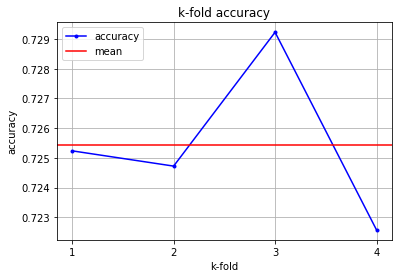

In [12]:
from implementations import build_k_indices
from tqdm import tqdm_notebook
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

def cross_validation_demo():
    seed = 1
    k_fold = 4
    #lambdas = np.logspace(-3, 1, 10)
    initial_w = init_w(tx_train)
    max_iters = 100
    gamma = 0.7
    k_indices = build_k_indices(y_train, k_fold, seed)
    results = []
    #for lambda_ in tqdm_notebook(lambdas):
    lambda_=0
    accs = []
    for k in tqdm_notebook(range(k_fold)):
        print(k)
        w_tr, acc = cross_validation(y_train, tx_train.T, initial_w, max_iters,  k_indices, k, gamma, lambda_)
        accs.append(acc)
    acc_mean = np.mean(accs)
    results.append(acc_mean)
    print(acc_mean)
    plt.plot(range(1,k_fold+1), accs, marker=".", color='b', label='accuracy')
    plt.axhline(y=acc_mean, color='r', label='mean')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel("k-fold")
    plt.ylabel("accuracy")
    plt.title("k-fold accuracy")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()

cross_validation_demo()

# Predict labels

In [199]:
from implementations import predict_labels

In [137]:
y_pred = predict_labels(w, tx_test)

array([-1., -1., -1., ..., -1., -1., -1.])

# Submission

In [198]:
from implementations import create_csv_submission

In [258]:
create_csv_submission(test_data_id, y_pred, "test6.csv")

Test n : algorithm / features / y / w
- - - - - - - - - - - - - - - - - - - 
Test 1 : least_squares / all features standardized / y = -1,1 / random init_w

Test 2 : least_squares / corr > 0.1 features standardized / y = -1,1 / random init_w

Test 3 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w

Test 4 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w / poly, degree=1

Test 5 : least_squares / all features standardized / y = -1,1 / random init_w / median + categorical

Test 6 : logistic_regressoin  /all features standardized / y = 0,1 / random init_w / median + categorical + balanced

## Further work

- balance output (batch numpy)
- median and category
- features engineering : features d'intéraction
- logistic regression 